In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import ast
from scipy.stats import pointbiserialr
from collections import Counter
from pySankey.sankey import sankey
os.chdir("./../..")
print(os.getcwd())

/Users/adamouazzani/Documents/GitHub/ada-2024-project-theadacuates


In [2]:
df_paths = pd.read_csv('data/output/processed_data/paths_processed.csv', low_memory=False)

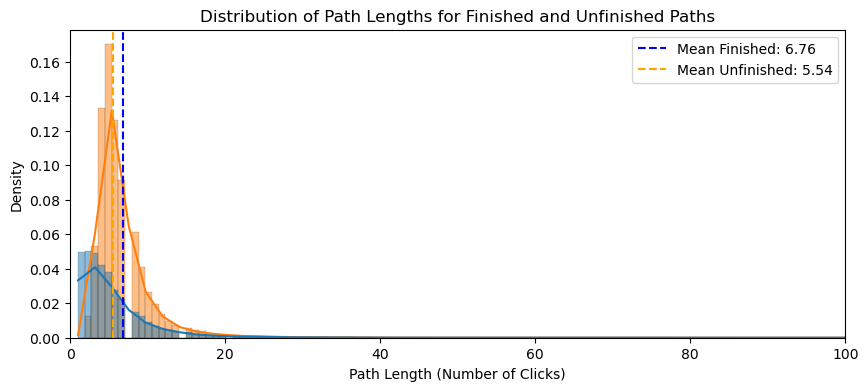

Mann-Whitney U test results for Finished vs. Unfinished Path Lengths: U = 772366749.0, p-value = 0.0


In [3]:
###################################
# Plot distributions
###################################

# Separate data into finished and unfinished paths
finished_paths = df_paths[df_paths['finished'] == True]
unfinished_paths = df_paths[df_paths['finished'] == False]

# Plot distribution of path lengths
plt.figure(figsize=(10, 4))
sns.histplot(df_paths, x='n_click', hue='finished', kde=True, bins=500, stat="density")

# Plot vertical lines at the means of finished and unfinished paths
mean_finished = finished_paths['n_click'].mean()
mean_unfinished = unfinished_paths['n_click'].mean()
plt.axvline(mean_finished, color='blue', linestyle='--', label=f'Mean Finished: {mean_finished:.2f}')
plt.axvline(mean_unfinished, color='orange', linestyle='--', label=f'Mean Unfinished: {mean_unfinished:.2f}')

# Titles and labels
plt.title('Distribution of Path Lengths for Finished and Unfinished Paths')
plt.xlabel('Path Length (Number of Clicks)')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.legend()
plt.show()

###################################
# Perform Mann-Whitney U test
###################################

finished_lengths = df_paths[df_paths['finished'] == True]['n_click']
unfinished_lengths = df_paths[df_paths['finished'] == False]['n_click']
u_stat, p_value = stats.mannwhitneyu(finished_lengths, unfinished_lengths)
print(f"Mann-Whitney U test results for Finished vs. Unfinished Path Lengths: U = {u_stat}, p-value = {p_value}")

In [4]:
# Step 1: Identify the last 4 unique combinations based on group size
last_4_combinations = df_paths.groupby(by=["source_link", "target_link"]).size().sort_values().tail(4).index

# Step 2: Filter the DataFrame to include only the last 4 combinations
df_last_4_cases = df_paths[df_paths.set_index(["source_link", "target_link"]).index.isin(last_4_combinations)]

# Step 3: Group by the last 4 combinations and "finished" column, then calculate the mean of 'n_clicks'
df_grouped = df_last_4_cases.groupby(["source_link", "target_link", "finished"])["n_click"].mean().unstack()

# Step 4: Calculate the mean difference and perform t-test
results = []
for (source, target) in last_4_combinations:
    # Filter the data for this (source_link, target_link)
    data = df_last_4_cases[(df_last_4_cases["source_link"] == source) & (df_last_4_cases["target_link"] == target)]
    
    # Separate the clicks for "True" (finished) and "False" (unfinished) paths
    finished_clicks = data[data["finished"] == True]["n_click"]
    unfinished_clicks = data[data["finished"] == False]["n_click"]
    
    # Perform the t-test (assuming unequal variance)
    t_stat, p_value = stats.ttest_ind(finished_clicks, unfinished_clicks, equal_var=False)
    
    # Store the results (mean difference, t-statistic, p-value)
    mean_diff = finished_clicks.mean() - unfinished_clicks.mean()
    results.append({
        "source_link": source,
        "target_link": target,
        "mean_diff": mean_diff,
        "t_stat": t_stat,
        "p_value": p_value
    })

# Step 5: Convert results into a DataFrame
df_results = pd.DataFrame(results)

# Step 6: Display the results
print(df_results)

  source_link target_link  mean_diff     t_stat       p_value
0     Pyramid        Bean   2.679587  11.532746  1.605381e-29
1     Theatre       Zebra   2.740315  14.538996  3.410645e-45
2    Asteroid      Viking   2.478926  13.851010  1.600135e-40
3       Brain   Telephone   2.896909  18.759760  2.702263e-72


# Time per path

In [5]:
df_paths.duration.describe()

count    74114.000000
mean       336.397793
std        574.935531
min          1.000000
25%         63.000000
50%        121.000000
75%        244.000000
max       4973.000000
Name: duration, dtype: float64

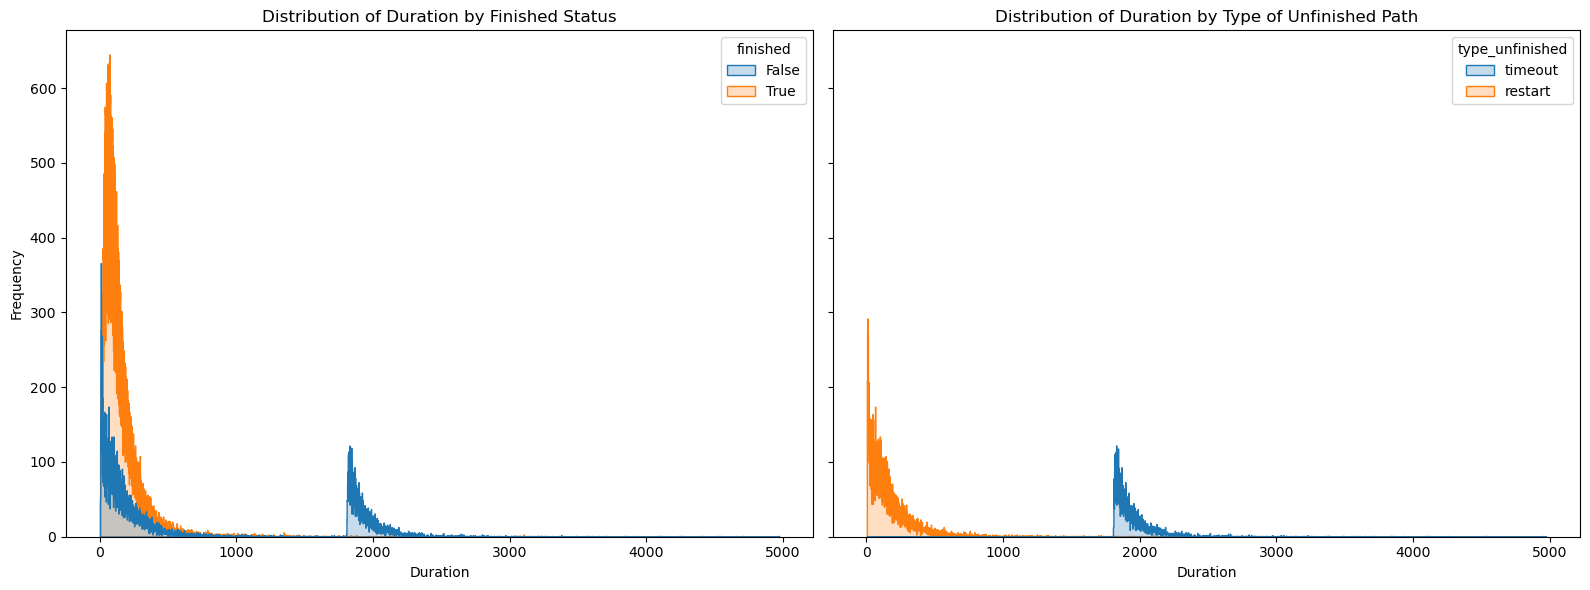

In [6]:
n_bins = 3000

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the first histogram: Duration by Finished Status
sns.histplot(data=df_paths, x="duration", hue="finished", bins=n_bins, element="step", ax=axes[0])
axes[0].set_title("Distribution of Duration by Finished Status")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Filter data for unfinished paths only
df_paths_unfinished = df_paths[df_paths["finished"] == False]

# Plot the second histogram: Duration by Type of Unfinished Path
sns.histplot(data=df_paths_unfinished, x="duration", hue="type_unfinished", bins=n_bins, element="step", ax=axes[1])
axes[1].set_title("Distribution of Duration by Type of Unfinished Path")
axes[1].set_xlabel("Duration")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

### Conclusion
We cannot conclude that unfinished paths indicate higher cognitive load based solely on time spent, as the increased mean duration in these cases is largely due to session timeouts. In these instances, players were not necessarily experiencing difficulty; rather, they abandoned the session, allowing time to accumulate passively. As a result, the prolonged durations in unfinished paths reflect a lapse in activity rather than active engagement or cognitive load. Thus, any assumptions about cognitive load based on these time differences would be unreliable.

# Cognitive shift per link

Moving from one category of knowledge to another (e.g., from science-related articles to arts-related articles) requires cognitive shifting, which can increase cognitive load. Cognitive shifting is known to engage the executive function of the brain and may lead to errors or abandonment if the shift is too taxing

In [7]:
df_cat = pd.read_csv("data/output/processed_data/categories_processed.csv")
display(df_cat.head(2))

df_cat = df_cat[["article_name", "article_category_1"]]
df_cat

article_to_category = dict(zip(df_cat["article_name"], df_cat["article_category_1"]))
article_to_category

,article_name,article_category,article_category_list,article_category_1,article_category_2,article_category_3
0,Áedán mac Gabráin,subject.History.British History.British Histor...,"['History', 'British History', 'British Histor...",History,British History,British History 1500 and before including Roma...
1,Åland,subject.Countries,['Countries'],Countries,NaN,NaN


{'Áedán mac Gabráin': 'History',
 'Åland': 'Countries',
 'Édouard Manet': 'People',
 'Éire': 'Countries',
 'Óengus I of the Picts': 'History',
 '€2 commemorative coins': 'Business Studies',
 '10th century': 'History',
 '11th century': 'History',
 '12th century': 'History',
 '13th century': 'History',
 '14th century': 'History',
 '15th Marine Expeditionary Unit': 'History',
 '15th century': 'History',
 '16 Cygni': 'Science',
 '16 Cygni Bb': 'Science',
 '16th century': 'History',
 '1755 Lisbon earthquake': 'History',
 '17th century': 'History',
 '1896 Summer Olympics': 'Everyday life',
 '18th century': 'History',
 '1928 Okeechobee Hurricane': 'Geography',
 '1973 oil crisis': 'History',
 '1980 eruption of Mount St. Helens': 'Geography',
 '1997 Pacific hurricane season': 'Geography',
 '19th century': 'History',
 '1 Ceres': 'Science',
 '1st century': 'History',
 '1st century BC': 'History',
 '2-6-0': 'Design and Technology',
 '2-8-0': 'Design and Technology',
 '2003 Atlantic hurricane seaso

In [8]:
def map_articles_to_categories(article_list):
    #print(article_list)
    article_list =  ast.literal_eval(article_list)
    list_cat = []
    for article in article_list:
        #print(article)
        list_cat.append(article_to_category.get(article, "Unknown"))
    return list_cat

In [9]:
# Create a nre col with path categtie

# Step 1: Create a dictionary to map article names to categories
article_to_category = dict(zip(df_cat["article_name"], df_cat["article_category_1"]))

# Step 2: Apply the function to each element in 'resolved_path_list_name' and create a new column
df_paths["resolved_path_list_category"] = df_paths["resolved_path_list_name"].apply(map_articles_to_categories)

# Display the updated DataFrame
df_paths.head()

,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name,resolved_path_list_category
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","['14th century', '15th century', '16th century...","[History, History, History, Geography, Geograp..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","['14th century', 'Europe', 'Africa', 'Atlantic...","[History, Geography, Geography, History, History]"
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"['14th century', 'Niger', 'Nigeria', 'British ...",14th century,African slave trade,True,NaN,8,0,2012-10-03 23:10:40,0.057971,17.250000,0.0,"[10, 2982, 2984, 694, 3755, 128, 379, 143]","[10, 2982, 2984, 694, 3755, 128, 379, 143]","['14th century', 'Niger', 'Nigeria', 'British ...","[History, Geography, Geography, History, Citiz..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"['14th century', 'Renaissance', 'Ancient Greec...",14th century,Greece,True,NaN,4,0,2010-02-08 08:25:25,0.108108,9.250000,0.0,"[10, 3464, 241, 1793]","[10, 3464, 241, 1793]","['14th century', 'Renaissance', 'Ancient Greec...","[History, History, History, Countries]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,"['14th century', 'Italy', 'Roman Catholic Chur...",14th century,John F. Kennedy,True,NaN,7,0,2013-04-23 17:27:08,0.040000,25.000000,0.0,"[10, 2183, 3529, 1836, 3542, 3342, 2266]","[10, 2183, 3529, 1836, 3542, 3342, 2266]","['14th century', 'Italy', 'Roman Catholic Chur...","[History, Countries, Religion, Science, People..."


In [10]:
# Create shift metric

def count_category_changes(category_list):
    if not category_list:  # Check if the list is empty
        return 0
    change_count = 0
    for i in range(1, len(category_list)):
        if category_list[i] != category_list[i - 1]:  # Check for a change
            change_count += 1
    return change_count

# Apply the function to each row in the DataFrame
df_paths["category_change_count"] = df_paths["resolved_path_list_category"].apply(count_category_changes)

df_paths.head(2)

,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,...,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name,resolved_path_list_category,category_change_count
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,...,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","['14th century', '15th century', '16th century...","[History, History, History, Geography, Geograp...",2
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,...,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","['14th century', 'Europe', 'Africa', 'Atlantic...","[History, Geography, Geography, History, History]",2


In [11]:
print(df_paths["category_change_count"].describe())

# remove outliers
df_paths = df_paths[df_paths["category_change_count"] <= 100]

print(df_paths["category_change_count"].describe())


count    74114.000000
mean         3.174798
std          3.144191
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max        252.000000
Name: category_change_count, dtype: float64
count    74113.000000
mean         3.171441
std          3.008430
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max         73.000000
Name: category_change_count, dtype: float64


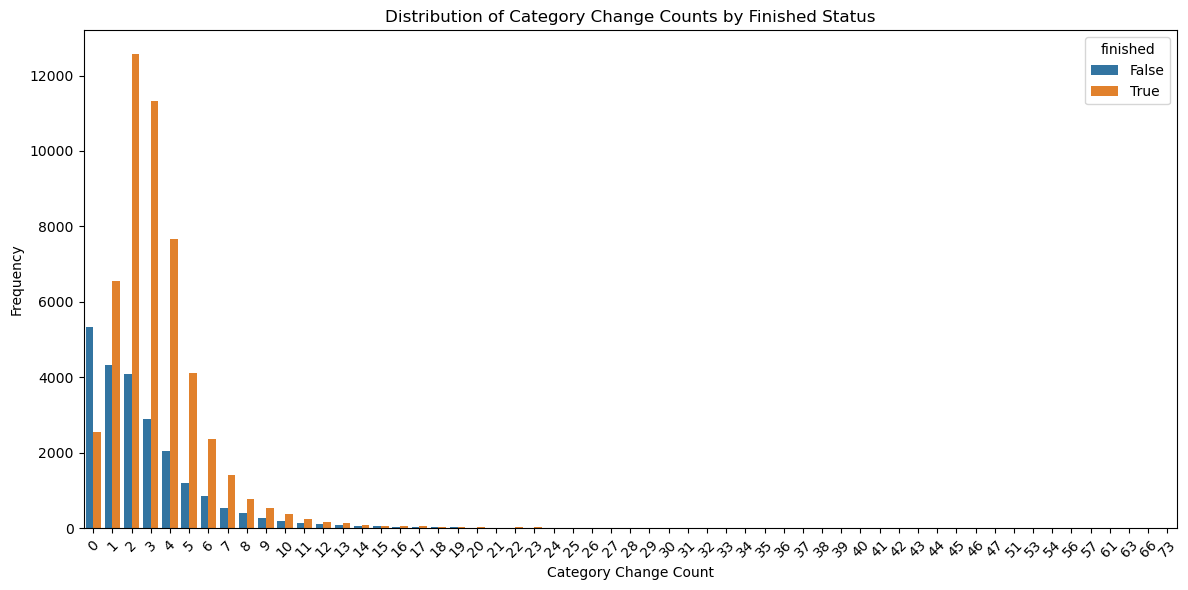

In [12]:
# Step 1: Ensure category change counts are computed
df_paths["category_change_count"] = df_paths["resolved_path_list_category"].apply(count_category_changes)

# Step 2: Aggregate the data
# Group by 'finished' and 'category_change_count' to count occurrences
agg_data = df_paths.groupby(['finished', 'category_change_count']).size().reset_index(name='count')

# Step 3: Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_data, x='category_change_count', y='count', hue='finished')#, palette={True: "green", False: "red"})

# Step 4: Customize the plot
plt.title("Distribution of Category Change Counts by Finished Status")
plt.xlabel("Category Change Count")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

In [13]:
finished_counts = df_paths[df_paths["finished"] == True]["category_change_count"]
not_finished_counts = df_paths[df_paths["finished"] == False]["category_change_count"]

t_stat, p_value = stats.ttest_ind(finished_counts, not_finished_counts, equal_var=False)  # Use Welch's t-test

alpha = 0.05  # Significance level
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups.")

T-statistic: 23.506
P-value: 0.000
Reject the null hypothesis: There is a significant difference between the means of the two groups.


### Conclusion

Unexpectedly, the significant shift per link is higher in finished paths, which challenges our initial assumption that a higher shift would correlate with increased cognitive load and greater difficulty. This finding suggests that the relationship between cognitive load and task completion is more complex than anticipated. (Pepito is totally wrong).

To explore this behavior further, we should conduct a connectivity analysis. By examining the connections between different elements of the paths, we can gain insights into how the structure and flow of information influence both cognitive load and task success. Understanding these dynamics will help clarify the reasons behind the observed shifts in finished versus unfinished paths.

# Sankey Diagram

In [14]:
# Only for finished paths
df_paths_finished = df_paths[df_paths["finished"] == True]

data = df_paths_finished["resolved_path_list_category"]

df = pd.DataFrame(data)

# Extract source (first) and target (last) elements
df['source'] = df['resolved_path_list_category'].apply(lambda x: x[0])
df['target'] = df['resolved_path_list_category'].apply(lambda x: x[-1])

display(df)

# # Count unique (source, target) pairs
# flow_counts = Counter(zip(df['source'], df['target']))

# # Convert to DataFrame for easier manipulation
# flow_df = pd.DataFrame(flow_counts.items(), columns=["pair", "value"])
# flow_df[['source', 'target']] = pd.DataFrame(flow_df['pair'].tolist(), index=flow_df.index)

# flow_df

,resolved_path_list_category,source,target
0,"[History, History, History, Geography, Geograp...",History,History
1,"[History, Geography, Geography, History, History]",History,History
2,"[History, Geography, Geography, History, Citiz...",History,History
3,"[History, History, History, Countries]",History,Countries
4,"[History, Countries, Religion, Science, People...",History,People
...,...,...,...
51275,"[People, History, Citizenship]",People,Citizenship
51276,"[People, History, People, History, History, Pe...",People,Language and literature
51277,"[People, Countries, Geography, Countries, Coun...",People,Everyday life
51278,"[Geography, Countries, Countries, People]",Geography,People


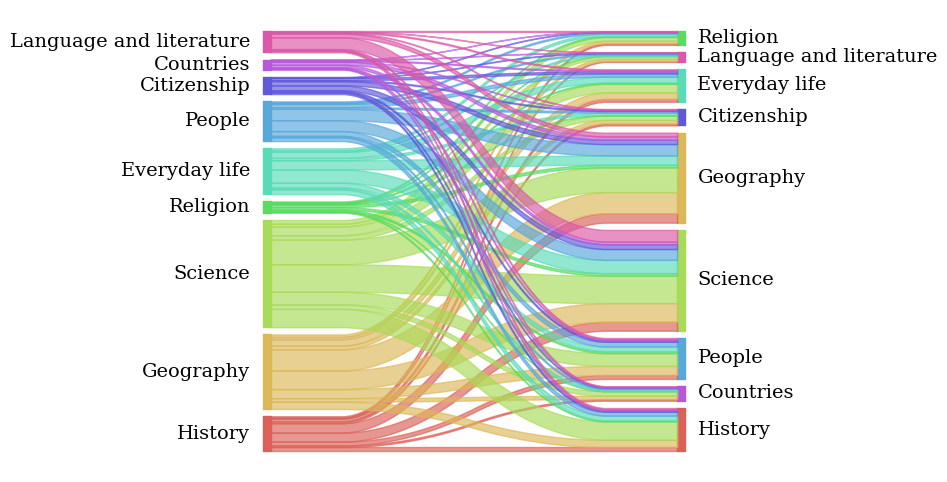

In [15]:
cat_to_use = ["History", "Geography", "Science", "Religion", "Everyday life", "Design and echnology", "People", "Countries", "Language and literature", "Citizenship"]
df = df[(df["source"].isin(cat_to_use)) & (df["target"].isin(cat_to_use))]
sankey(df["source"], df["target"], aspect=20)#), colorDict=colors, fontsize=12)
